In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay, fbeta_score, accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix


import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout      # create layers
from keras.metrics import CategoricalAccuracy, Recall, Precision, AUC
from keras.backend import clear_session
from keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import StackingClassifier

import os
import sys
sys.path.append("..")
from src.data.preprocessing import load_preprocess_data
from src.features.feature_engineering import create_features, unwrap_smart_7



# Read Data

In [2]:
# read data
repo_path = os.getcwd() + "/../"
df_source = load_preprocess_data(path=repo_path)
df = create_features(df_source, interval=30, trigger_percentage=0.05)
df = unwrap_smart_7(df)

  0%|          | 0/608 [00:00<?, ?it/s]../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.smart_7_mod[temp_data.index] = temp_data.smart_7_raw
100%|██████████| 608/608 [00:12<00:00, 47.89it/s]


# Check Duplicates

In [3]:
serials_failed = df_source.query("failure == 1")["serial_number"].to_list()
serials_failed_unique = set(serials_failed)
print("Number of failed days:", len(serials_failed))
print("Number of unique serial number on the failed day:", len(serials_failed_unique))
tmp = serials_failed[:]
for serial in serials_failed_unique:
    tmp.remove(serial)

if len(tmp) == 0:
    print("There is no duplicate")
else:
    print(f"There {len(tmp)} duplicates")
    print("   duplicated serial numbers",tmp)
    df.drop(298155, inplace=True)
    df.drop(309081, inplace=True)
    df.reset_index(inplace=True)
    print("Number of rows before drop:", len(df_source))
    print("Number of rows after drop:", len(df))   

Number of failed days: 610
Number of unique serial number on the failed day: 608
There 2 duplicates
   duplicated serial numbers ['Z302SQFX', 'Z303VDR4']
Number of rows before drop: 462966
Number of rows after drop: 462964


# Create Target and Features

In [4]:
def get_smart_999_accumulated(df_in):
    df_tmp = df_in.drop(["index"], axis=1).copy()
    serials = df_tmp['serial_number'].unique()
    #serials = serials[0:2]
    #print(serials)
    for i, serial in enumerate(serials):
        df_serial = df_tmp.query('serial_number == @serial').sort_values(by='date').reset_index(drop=True)
        df_serial['smart_999_accumulated'] = df_serial['smart_999'].cumsum()
        if i == 0:
            df = df_serial.copy()
        else:
            df = pd.concat([df, df_serial], ignore_index=True)
    return df

In [5]:
# select features
"""
cols = ['date', 'serial_number', 'model', 'failure', 'smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'date_failure', 'countdown','smart_999']
df = df[pd.Index(cols)]
"""

# create smart_999_accumulated
df = get_smart_999_accumulated(df)

# create target
df['failure_in_30_days'] = df['countdown'].apply(lambda x : 1 if x <= 30 else 0)
df.head(5)

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999,smart_999_accumulated,failure_in_30_days
0,2019-01-01,Z304JG86,ST4000DM000,0,168829568.0,10.0,0.0,257899631.0,27368.0,10.0,...,False,False,False,False,False,False,False,0,0,0
1,2019-01-02,Z304JG86,ST4000DM000,0,50913560.0,10.0,0.0,259688596.0,27392.0,10.0,...,False,False,False,False,False,False,False,0,0,0
2,2019-01-03,Z304JG86,ST4000DM000,0,176805800.0,10.0,0.0,261018343.0,27416.0,10.0,...,False,False,False,False,False,False,False,0,0,0
3,2019-01-04,Z304JG86,ST4000DM000,0,217666344.0,10.0,0.0,261751900.0,27440.0,10.0,...,False,False,False,False,False,False,False,0,0,0
4,2019-01-05,Z304JG86,ST4000DM000,0,218092400.0,10.0,0.0,263166092.0,27464.0,10.0,...,False,False,False,False,False,False,False,0,0,0


# Split Data

In [6]:
# split data
RSEED = 420
serial_train, serial_test, dummy1, dummy2 = train_test_split(df['serial_number'].unique(), df['serial_number'].unique(), test_size=0.2, random_state=RSEED)
df_train = df[df['serial_number'].isin(serial_train)]
df_test = df[df['serial_number'].isin(serial_test)]

print("number of unique disk in data:", df["serial_number"].nunique())
print("number of unique disk in train:", df_train["serial_number"].nunique())
print("number of unique disk in test:", df_test["serial_number"].nunique())

number of unique disk in data: 608
number of unique disk in train: 486
number of unique disk in test: 122


In [7]:
df.columns

Index(['date', 'serial_number', 'model', 'failure', 'smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'date_failure', 'countdown', 'smart_7_mod', 'smart_1_raw_ema',
       'smart_4_raw_ema', 'smart_5_raw_ema', 'smart_7_raw_ema',
       'smart_9_raw_ema', 'smart_12_raw_ema', 'smart_183_raw_ema',
       'smart_184_raw_ema', 'smart_187_raw_ema', 'smart_188_raw_ema',
       'smart_189_raw_ema', 'smart_190_raw_ema', 'smart_192_raw_ema',
       'smart_193_raw_ema', 'smart_194_raw_ema', 'smart_197_raw_ema',
       'smart_198_raw_ema', 'smart_199_raw_ema', 'smart_240_raw_ema',
       'smart_241_raw_ema', 'smart_242_raw_ema', 'smart_7_mod_ema',
       'smart_4_ra

# Set X and y

In [8]:
# set X and y

cols_feature = [
    'smart_1_raw', 
    'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
    'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
    'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
    'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
    'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
    'smart_999']#, 'smart_999_accumulated']

"""
cols_feature =['smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999', 'smart_999_accumulated',
       'smart_4_raw_trigger', 'smart_5_raw_trigger', 'smart_12_raw_trigger',
       'smart_183_raw_trigger', 'smart_184_raw_trigger',
       'smart_187_raw_trigger', 'smart_188_raw_trigger',
       'smart_189_raw_trigger', 'smart_193_raw_trigger',
       'smart_192_raw_trigger', 'smart_197_raw_trigger',
       'smart_198_raw_trigger', 'smart_199_raw_trigger']
"""
"""
cols_feature = ['smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'date_failure', 'smart_1_raw_ema',
       'smart_4_raw_ema', 'smart_5_raw_ema', 'smart_7_raw_ema',
       'smart_9_raw_ema', 'smart_12_raw_ema', 'smart_183_raw_ema',
       'smart_184_raw_ema', 'smart_187_raw_ema', 'smart_188_raw_ema',
       'smart_189_raw_ema', 'smart_190_raw_ema', 'smart_192_raw_ema',
       'smart_193_raw_ema', 'smart_194_raw_ema', 'smart_197_raw_ema',
       'smart_198_raw_ema', 'smart_199_raw_ema', 'smart_240_raw_ema',
       'smart_241_raw_ema', 'smart_242_raw_ema', 'smart_7_mod_ema',
       'smart_4_raw_trigger', 'smart_5_raw_trigger', 'smart_12_raw_trigger',
       'smart_183_raw_trigger', 'smart_184_raw_trigger',
       'smart_187_raw_trigger', 'smart_188_raw_trigger',
       'smart_189_raw_trigger', 'smart_193_raw_trigger',
       'smart_192_raw_trigger', 'smart_197_raw_trigger',
       'smart_198_raw_trigger', 'smart_199_raw_trigger', 'smart_999',
       'smart_999_accumulated'
]
"""

X_train = df_train[cols_feature]
y_train = df_train['failure_in_30_days']

X_test = df_test[cols_feature]
y_test = df_test['failure_in_30_days']

# Log and Scale

In [9]:
# log 
X_train_log = X_train.apply(lambda x : np.log10(x+1))
X_test_log = X_test.apply(lambda x : np.log10(x+1))

# scale
scaler = MinMaxScaler()
scaler.fit(X_train_log)

X_train_log_scaled = pd.DataFrame(scaler.transform(X_train_log), columns=X_train_log.columns)
X_test_log_scaled = pd.DataFrame(scaler.transform(X_test_log), columns=X_test_log.columns)
X_train_log_scaled.describe()

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_mod,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999
count,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,...,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000,370043.000000
mean,0.948253,0.389753,0.024630,0.546493,0.716214,0.386488,0.073106,0.002416,0.079463,0.003764,...,0.042407,0.578725,0.275742,0.040067,0.040067,0.006002,0.714566,0.801455,0.391742,0.037832
std,0.051911,0.111522,0.118222,0.049181,0.119020,0.113523,0.141969,0.036995,0.164392,0.046239,...,0.090095,0.138854,0.097142,0.109328,0.109328,0.062526,0.119643,0.102936,0.132710,0.140741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.928478,0.313298,0.000000,0.516562,0.630332,0.313724,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.516263,0.202956,0.000000,0.000000,0.000000,0.628150,0.765032,0.287169,0.000000
50%,0.964156,0.385267,0.000000,0.548735,0.717970,0.385791,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.565280,0.270698,0.000000,0.000000,0.000000,0.716239,0.819232,0.383345,0.000000
75%,0.985102,0.455361,0.000000,0.575507,0.806426,0.455980,0.105331,0.000000,0.000000,0.000000,...,0.000000,0.616515,0.349349,0.000000,0.000000,0.000000,0.805285,0.865367,0.480364,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Function for Printing Metrics

In [10]:
def show_metrics(y_train, y_train_pred, y_test, y_test_pred, digit=20):
    for data in ["train", "test"]:
        print("=======================================")
        print(f"# For {data} data:")
        if data == "train":
            y_true = y_train
            y_pred = y_train_pred
        else:
            y_true = y_test
            y_pred = y_test_pred
        f2 = fbeta_score(y_true, y_pred, beta=2)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        print("  f2-score  :", (f2*100).round(digit), "%")
        print("  precision :", (pre*100).round(digit), "%")
        print("  recall    :", (rec*100).round(digit), "%")
        print("  accuracy  :", (acc*100).round(digit), "%")

    fig, axes = plt.subplots(2,2,figsize=(6, 6))
    fig.suptitle("Confusion Matrix")
    for i in range(4):
        if i//2 == 0:
            train_or_test = "Train"
            y_true = y_train
            y_pred = y_train_pred
        else:
            train_or_test = "Test"
            y_true = y_test
            y_pred = y_test_pred
        if i%2 == 0:
            scale = " (log scale)"
            data = np.log10(confusion_matrix(y_true, y_pred))
        else:
            data = confusion_matrix(y_true, y_pred)
            scale = ""
        sns.heatmap(data, annot=True, ax=axes[i//2, i%2])
        axes[i//2,i%2].set_title(f"{train_or_test}{scale}")
        axes[i//2,i%2].set_ylabel("Truth", fontsize=25)
        axes[i//2,i%2].set_xlabel("Prediction", fontsize=25)

    fig.tight_layout()
    plt.show()

def show_roc_curve(y_train, y_train_score, y_test, y_test_score):
    RocCurveDisplay.from_predictions(y_train, y_train_score)
    RocCurveDisplay.from_predictions(y_test, y_test_score)


# Neural Network

Check again the shape and features in X:

In [11]:
print(X_train.shape)
X_train.columns

(370043, 22)


Index(['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_mod',
       'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw',
       'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw',
       'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw',
       'smart_242_raw', 'smart_999'],
      dtype='object')

Construct layers and compile:

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-22 02:04:22.252806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-22 02:04:22.258884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                690       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,651
Trainable params: 1,651
Non-trainable params: 0
_________________________________________________________________
None


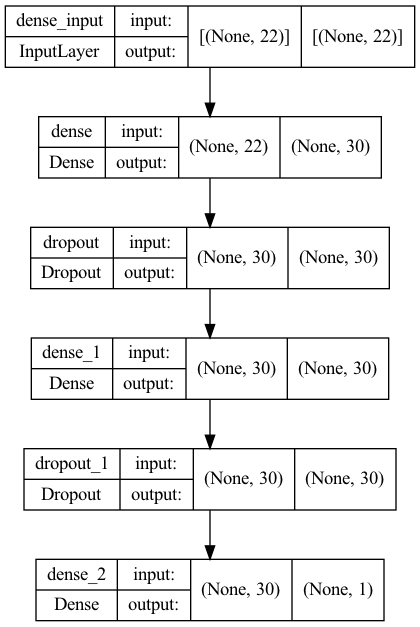

In [12]:
# clear session after repeated runs
clear_session()

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.2))
#model.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


#optz = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)
#optz = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
#optz = tf.keras.optimizers.Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999) # gives error during fit
#optz = tf.keras.optimizers.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)

# Compiling the ANN
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['AUC', 'Recall', 'Precision', 'accuracy'])
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['Recall', 'Precision']
              )

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True, dpi=96)

Train the network:

Epoch 1/150


2022-03-22 02:04:23.471289: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 02:04:24.220738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 - 2s - loss: 0.9151 - recall: 0.1375 - precision: 0.0368 - val_loss: 0.6878 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 2s/epoch - 227ms/step
Epoch 2/150


2022-03-22 02:04:25.229446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 - 0s - loss: 0.9107 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6801 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 332ms/epoch - 42ms/step
Epoch 3/150
8/8 - 0s - loss: 0.9039 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6666 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 316ms/epoch - 39ms/step
Epoch 4/150
8/8 - 0s - loss: 0.8919 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6428 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 318ms/epoch - 40ms/step
Epoch 5/150
8/8 - 0s - loss: 0.8719 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6037 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 318ms/epoch - 40ms/step
Epoch 6/150
8/8 - 0s - loss: 0.8419 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.5460 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 326ms/epoch - 41ms/step
Epoch 7/150
8/8 - 0s - loss: 0.8038 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.4731 - val_recall: 0.0

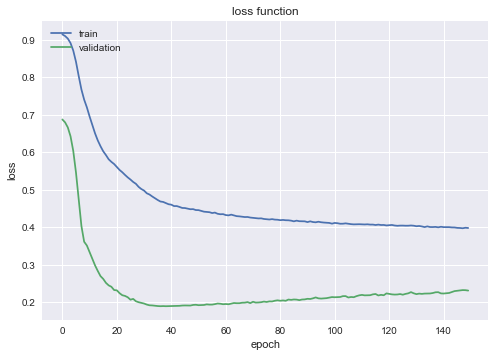

2022-03-22 02:05:16.432540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [13]:
# Train the ANN
#training = model.fit(X_train, y_train, batch_size = 10000, validation_split=0.2, epochs = 100, class_weight={0:1.0, 1:1000.0})
training = model.fit(X_train_log_scaled, y_train, batch_size = 40000, validation_split=0.2, epochs = 150, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)

# summarize history for accuracy
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# prediction
y_train_pred = model.predict(X_train_log_scaled)
y_test_pred = model.predict(X_test_log_scaled)

# For train data:
  f2-score  : 42.64615319275444 %
  precision : 23.664054675072173 %
  recall    : 53.34351550567766 %
  accuracy  : 91.09860205435585 %
# For test data:
  f2-score  : 39.64242449559296 %
  precision : 21.56083153470408 %
  recall    : 50.15856236786468 %
  accuracy  : 90.53927529837173 %


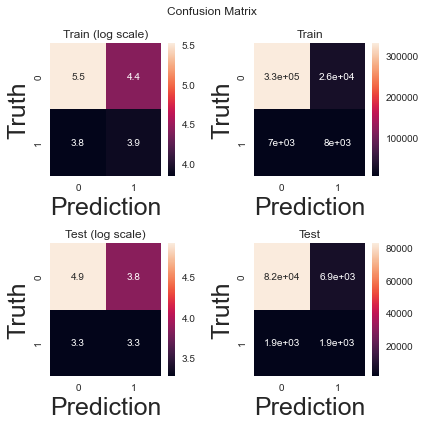

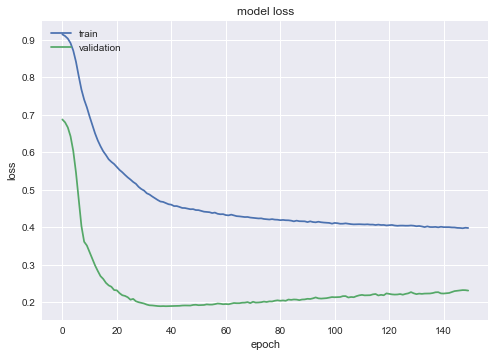

In [14]:
# evaluate metrics
show_metrics(y_train, y_train_pred.round(), y_test, y_test_pred.round(), digit=20)

# summarize history for accuracy
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.ylim(0,2.4)
plt.show()

[[5.9451962e-05]
 [5.8454636e-05]
 [6.7564921e-05]
 ...
 [4.8796058e-02]
 [3.0239878e-02]
 [3.1723097e-02]]


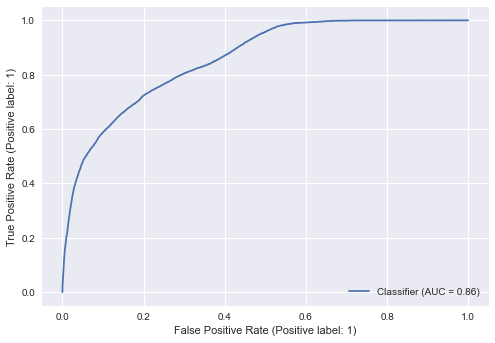

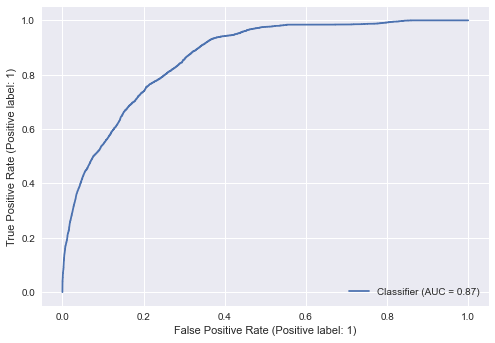

In [15]:
print(y_test_pred)
show_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

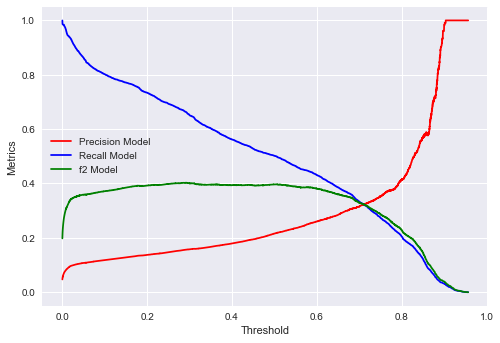

Max f2: 0.4029586750281396; Threshold: 0.2923865020275116
Recall: 0.662262156448203; Precision: 0.15702738266808697


In [16]:

pre, rec, thresholds = precision_recall_curve(y_test, y_test_pred)
f2 = (5)*(pre*rec)/(4*pre + rec)

plt.plot(thresholds, pre[1:],'r-',label = 'Precision Model')
plt.plot(thresholds, rec[1:],'b-',label = 'Recall Model')
plt.plot(thresholds, f2[1:],'g-',label = 'f2 Model')

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.show()

# max f2
print(f'Max f2: {np.nanmax(f2)}; Threshold: {thresholds[np.nanargmax(f2)]}')
print(f'Recall: {rec[np.nanargmax(f2)]}; Precision: {pre[np.nanargmax(f2)]}')

In [17]:
f2

array([0.19805711, 0.19800685, 0.19800892, ..., 0.00066059, 0.00033032,
       0.        ])

# Feature Importance

In [18]:
"""
import shap

# load your data here, e.g. X and y
# create and fit your model here

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_log_scaled)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_log_scaled.iloc[0,:])

shap.summary_plot(shap_values, X_train_log_scaled, plot_type="bar")
"""

'\nimport shap\n\n# load your data here, e.g. X and y\n# create and fit your model here\n\n# load JS visualization code to notebook\nshap.initjs()\n\n# explain the model\'s predictions using SHAP\n# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(X_train_log_scaled)\n\n# visualize the first prediction\'s explanation (use matplotlib=True to avoid Javascript)\nshap.force_plot(explainer.expected_value, shap_values[0,:], X_train_log_scaled.iloc[0,:])\n\nshap.summary_plot(shap_values, X_train_log_scaled, plot_type="bar")\n'

# Save and Load Model

In [19]:
# save model
if False:
    path_save = './30x2_weight10'
    model.save(path_save)

In [20]:
# load model
model_from_load = None
if False:
    path_load = './30x2_weight10'
    model_from_load = load_model(path_load)

# Prediction from the Loaded Model

In [21]:
# prediction
y_train_pred = model_from_load.predict(X_train_log_scaled)
y_test_pred = model_from_load.predict(X_test_log_scaled)

AttributeError: 'NoneType' object has no attribute 'predict'

# For train data:
  f2-score  : 45.41934575491622 %
  precision : 23.79810647977376 %
  recall    : 58.767268862911784 %
  accuracy  : 90.59661786897742 %
# For test data:
  f2-score  : 40.49105387337789 %
  precision : 18.293359982234065 %
  recall    : 58.123125771741044 %
  accuracy  : 87.92744174218932 %


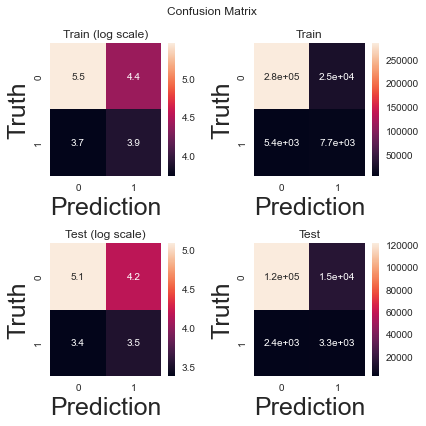

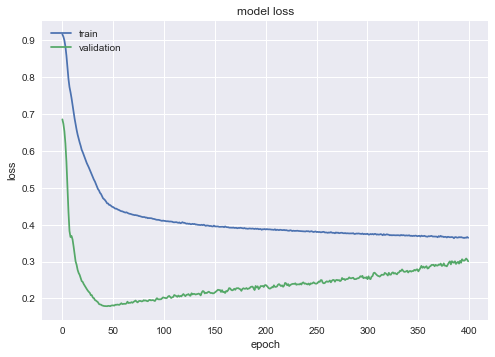

In [ ]:
# evaluate metrics
show_metrics(y_train, y_train_pred.round(), y_test, y_test_pred.round(), digit=20)

# summarize history for accuracy
plt.plot((training.history['loss']))
plt.plot((training.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.ylim(0,2.4)
plt.show()

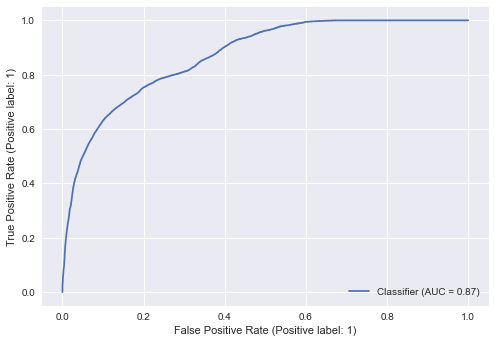

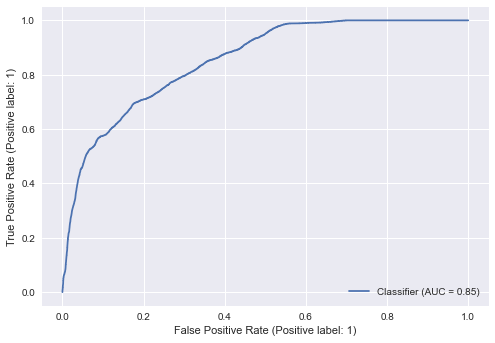

In [ ]:
show_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

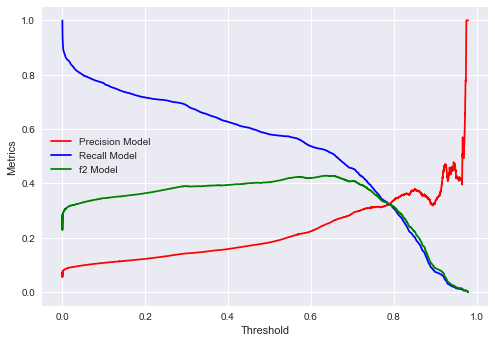

Max f2: 0.4288037638312084; Threshold: 0.6383904218673706
Recall: 0.5209031575233727; Precision: 0.25116951603300164


In [ ]:
pre, rec, thresholds = precision_recall_curve(y_test, y_test_pred)
f2 = (5)*(pre*rec)/(4*pre + rec)

plt.plot(thresholds, pre[1:],'r-',label = 'Precision Model')
plt.plot(thresholds, rec[1:],'b-',label = 'Recall Model')
plt.plot(thresholds, f2[1:],'g-',label = 'f2 Model')

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.show()

# max f2
print(f'Max f2: {np.nanmax(f2)}; Threshold: {thresholds[np.nanargmax(f2)]}')
print(f'Recall: {rec[np.nanargmax(f2)]}; Precision: {pre[np.nanargmax(f2)]}')

# Wrapping for sklearn stacking

Function for creating an ANN model:

In [3]:
def create_ann_model(n_feature): # n_feature = X_train.shape[1]

    # initiate the instance
    model = Sequential()

    # layers
    model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu', input_dim=n_feature))
    model.add(Dropout(0.2))
    model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

    # tuning optimizer (adam is the best)
    #optz = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)
    #optz = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
    #optz = tf.keras.optimizers.Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999) # gives error during fit
    #optz = tf.keras.optimizers.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)

    # compiling the ANN
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['Recall', 'Precision'])
    
    return model


Wrapping with KerasClassifier:

In [6]:
ann_classifier = KerasClassifier(build_fn=create_ann_model, epochs=150, batch_size= 40000, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)
ann_classifier._estimator_type = "classifier"


/var/folders/4f/mz1b5sg57p7324fdvfrshs1c0000gn/T/ipykernel_79020/1631673081.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_classifier = KerasClassifier(build_fn=create_ann_model, epochs=150, batch_size= 40000, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)


In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
estimators= [('ANN', ann_classifier)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

#X, y = make_classification()

# Stacking